In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
zip_file = keras.utils.get_file(
    fname="webkb.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/WebKB.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "webkb")

In [ ]:
citations_cornell = pd.read_csv(
    os.path.join(data_dir, "cornell.cites"),
    sep="\t",
    header=None,
    names = ['urls']
)

citations_texas = pd.read_csv(
    os.path.join(data_dir, "texas.cites"),
    sep="\t",
    header=None,
    names = ['urls']
)

citations_washington = pd.read_csv(
    os.path.join(data_dir, "washington.cites"),
    sep="\t",
    header=None,
    names = ['urls']
)

citations_wisconsin = pd.read_csv(
    os.path.join(data_dir, "wisconsin.cites"),
    sep="\t",
    header=None,
    names = ['urls']
)

citations = citations_cornell.append(citations_texas.append(citations_washington.append(citations_wisconsin,  ignore_index=True),  ignore_index=True),  ignore_index=True)

In [ ]:
citations['urls'] .str.split(" ")

citations = citations["urls"].str.split(" ", n = 1, expand = True)
citations.rename(columns = {0 : 'source', 1 : 'target'}, inplace = True)
citations.head()

,source,target
0,http://cam.cornell.edu/~baggett/index.html,http://www.cs.cornell.edu/info/people/lnt/lnt....
1,http://cam.cornell.edu/ph/index.html,http://www.cs.cornell.edu/info/people/vavasis/...
2,http://cs.cornell.edu/info/courses/current/cs4...,http://www.cs.cornell.edu/info/people/diyu/y.html
3,http://cs.cornell.edu/info/courses/fall-95/cs4...,http://www.cs.cornell.edu/info/people/indira/h...
4,http://cs.cornell.edu/info/courses/fall-95/cs4...,http://www.cs.cornell.edu/info/people/seena/ho...


In [ ]:
column_names = ["url"] + [f"term_{idx}" for idx in range(1703)] + ["subject"]
urls_cornell = pd.read_csv(
    os.path.join(data_dir, "cornell.content"), sep = "\t" , header = None, names=column_names)

urls_texas = pd.read_csv(
    os.path.join(data_dir, "texas.content"), sep = "\t", header = None, names=column_names)

urls_washington = pd.read_csv(
    os.path.join(data_dir, "washington.content"), sep = "\t", header = None, names=column_names)

urls_wisconsin = pd.read_csv(
    os.path.join(data_dir, "wisconsin.content"), sep = "\t", header = None, names=column_names)

urls = urls_cornell.append(urls_texas.append(urls_washington.append(urls_wisconsin,  ignore_index=True),  ignore_index=True),  ignore_index=True)

In [ ]:
urls['subject'].value_counts()

student    415
course     218
faculty    125
project     80
staff       39
Name: subject, dtype: int64

In [ ]:
class_values = sorted(urls["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
url_idx = {name: idx for idx, name in enumerate(sorted(urls["url"].unique()))}

urls["url"] = urls["url"].apply(lambda name: url_idx[name])
citations["source"] = citations["source"].apply(lambda name: url_idx[name])
citations["target"] = citations["target"].apply(lambda name: url_idx[name])
urls["subject"] = urls["subject"].apply(lambda value: class_idx[value])

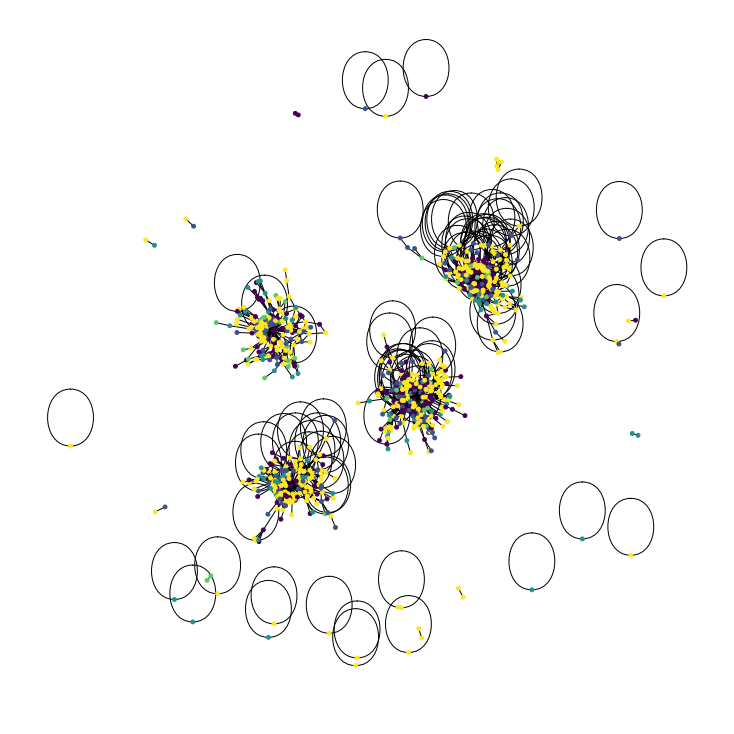

In [78]:
plt.figure(figsize=(10, 10))
webkb_graph = nx.from_pandas_edgelist(citations)
subjects = list(urls[urls["url"].isin(list(webkb_graph.nodes))]["subject"])
nx.draw_spring(webkb_graph, node_size=15, node_color=subjects)

In [ ]:
train_data, test_data = [], []

for _, group_data in urls.groupby("subject"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (700, 1705)
Test data shape: (177, 1705)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
feature_names = set(urls.columns) - {"url", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1703)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           62524       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
3/3 [==============================] - 5s 320ms/step - loss: 3.6229 - acc: 0.1950 - val_loss: 1.3569 - val_acc: 0.5905
Epoch 2/300
3/3 [==============================] - 0s 45ms/step - loss: 1.9337 - acc: 0.4487 - val_loss: 1.2484 - val_acc: 0.6190
Epoch 3/300
3/3 [==============================] - 0s 34ms/step - loss: 1.7724 - acc: 0.5479 - val_loss: 1.2279 - val_acc: 0.6190
Epoch 4/300
3/3 [==============================] - 0s 38ms/step - loss: 1.6349 - acc: 0.5412 - val_loss: 1.2415 - val_acc: 0.5524
Epoch 5/300
3/3 [==============================] - 0s 37ms/step - loss: 1.3683 - acc: 0.6101 - val_loss: 1.2251 - val_acc: 0.5524
Epoch 6/300
3/3 [==============================] - 0s 50ms/step - loss: 1.3092 - acc: 0.5916 - val_loss: 1.1485 - val_acc: 0.6762
Epoch 7/300
3/3 [==============================] - 0s 39ms/step - loss: 1.2750 - acc: 0.6336 - val_loss: 1.0378 - val_acc: 0.7143
Epoch 8/300
3/3 [==============================] - 0s 39ms/step - loss: 1.0642 - acc: 0.6

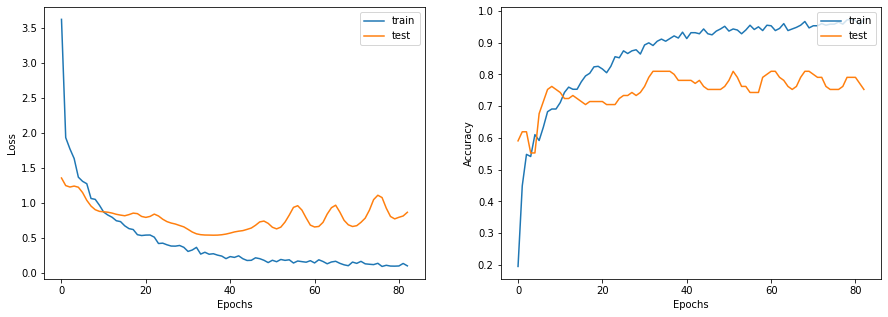

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 85.31%


In [ ]:
# make predictions
pred = baseline_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)

6/6 [==============================] - 1s 7ms/step


In [ ]:
print("Confusion matrix: ")
print(confusion_matrix(y_test , y_pred))
print(" ")
print("F1 score: ", f1_score(y_test , y_pred, average = 'macro'))

Confusion matrix: 
[[41  1  0  0  0]
 [ 0 22  0  0  4]
 [ 3  4 11  0  5]
 [ 1  3  0  0  1]
 [ 4  0  0  0 77]]
 
F1 score:  0.6501077354018531
